# MDVRP con BRKGA
## Sergio Esteban Cuevas Clavijo - 202020957

#### Librerías

In [1]:
import os
import random
import math
import matplotlib.pyplot as plt

#### Lector de archivos

In [2]:
def read_mdvrp_dat(filename):
    """
    Lee una instancia MDVRP desde un archivo .dat y devuelve la información en un diccionario.
    
    Formato asumido:
      - Primera línea: <param> <vehículos_por_deposito> <capacidad> <número_de_depositos>
      - Siguientes <número_de_depositos> líneas: coordenadas (x, y) de cada depósito
      - Resto de líneas: datos de clientes en formato:
             id  x  y  demanda  tiempo_servicio  [otros parámetros...]
    """
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    
    header_vals = lines[0].split()
    param, vehicles_per_depot, capacity, num_depots = map(int, header_vals[:4])
    
    depots = []
    for i in range(1, 1 + num_depots):
        parts = lines[i].split()
        x, y = map(float, parts[:2])
        depots.append((x, y))
    
    customers = []
    for line in lines[1 + num_depots:]:
        parts = line.split()
        cust_id = int(parts[0])
        x = float(parts[1])
        y = float(parts[2])
        demand = int(parts[3])
        service = float(parts[4])
        extra = list(map(int, parts[5:])) if len(parts) > 5 else []
        customers.append({
            'id': cust_id,
            'x': x,
            'y': y,
            'demand': demand,
            'service': service,
            'extra': extra
        })
    
    return {
        'header': {
            'param': param,
            'vehicles_per_depot': vehicles_per_depot,
            'capacity': capacity,
            'num_depots': num_depots
        },
        'depots': depots,
        'customers': customers
    }

#### BRKGA

In [3]:
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def decode_solution(chromosome, instance):
    """
    Decodifica un cromosoma en una solución para el MDVRP.
    
    Procedimiento:
      1. Ordena los clientes según el cromosoma.
      2. Para cada cliente, se calculan las distancias a cada depósito y se guardan
         todos los depósitos que tengan la misma mínima distancia (dentro de una tolerancia).
         Luego se asigna el cliente aleatoriamente a uno de ellos.
      3. Para cada depósito, se agrupan los clientes en rutas secuenciales, agregando
         clientes mientras la suma de demandas no supere la capacidad. Cuando se supera,
         se cierra la ruta (se añade el regreso al depósito) y se inicia una nueva ruta.
      4. Se calcula la distancia total (suma de las distancias de todas las rutas).
    
    Retorna:
      - total_distance: el valor del objetivo (minimizar la distancia total)
      - solution: diccionario con las rutas para cada depósito.
    """
    customers = instance['customers']
    depots = instance['depots']
    capacity = instance['header']['capacity']
    
    # Ordena los clientes según el cromosoma
    sorted_customers = [cust for _, cust in sorted(zip(chromosome, customers), key=lambda x: x[0])]
    
    depot_assignments = {i: [] for i in range(len(depots))}
    tol = 1e-6
    for cust in sorted_customers:
        cust_point = (cust['x'], cust['y'])
        best_dist = float('inf')
        best_depots = []
        for i, depot in enumerate(depots):
            d = euclidean_distance(cust_point, depot)
            if d < best_dist - tol:
                best_dist = d
                best_depots = [i]
            elif abs(d - best_dist) < tol:
                best_depots.append(i)
        # Asigna aleatoriamente si hay más de un depósito con distancia mínima
        chosen_depot = random.choice(best_depots)
        depot_assignments[chosen_depot].append(cust)
    
    solution = {}
    total_distance = 0.0
    for depot_index, cust_list in depot_assignments.items():
        depot = depots[depot_index]
        routes = []
        current_route = []
        current_load = 0
        route_distance = 0.0
        prev_point = depot
        
        for cust in cust_list:
            if current_load + cust['demand'] <= capacity:
                current_route.append(cust['id'])
                current_load += cust['demand']
                curr_point = (cust['x'], cust['y'])
                route_distance += euclidean_distance(prev_point, curr_point)
                prev_point = curr_point
            else:
                route_distance += euclidean_distance(prev_point, depot)
                routes.append({'route': current_route.copy(), 'distance': route_distance, 'load': current_load})
                total_distance += route_distance
                current_route = [cust['id']]
                current_load = cust['demand']
                route_distance = euclidean_distance(depot, (cust['x'], cust['y']))
                prev_point = (cust['x'], cust['y'])
        if current_route:
            route_distance += euclidean_distance(prev_point, depot)
            routes.append({'route': current_route.copy(), 'distance': route_distance, 'load': current_load})
            total_distance += route_distance
        
        solution[depot_index] = routes

    return total_distance, solution

class BRKGA:
    def __init__(self, instance, pop_size=50, elite_fraction=0.2, mutant_fraction=0.1, inheritance_prob=0.7, generations=100):
        self.instance = instance
        self.num_customers = len(instance['customers'])
        self.pop_size = pop_size
        self.elite_size = max(1, int(pop_size * elite_fraction))
        self.mutant_size = int(pop_size * mutant_fraction)
        self.inheritance_prob = inheritance_prob
        self.generations = generations
        self.population = []
    
    def random_chromosome(self):
        return [random.random() for _ in range(self.num_customers)]
    
    def initialize_population(self):
        self.population = []
        for _ in range(self.pop_size):
            chrom = self.random_chromosome()
            fitness = self.evaluate(chrom)
            self.population.append((chrom, fitness))
        self.population.sort(key=lambda x: x[1])
    
    def evaluate(self, chrom):
        total_distance, _ = decode_solution(chrom, self.instance)
        return total_distance
    
    def biased_crossover(self, elite_parent, non_elite_parent):
        child = []
        for gene_e, gene_n in zip(elite_parent, non_elite_parent):
            if random.random() < self.inheritance_prob:
                child.append(gene_e)
            else:
                child.append(gene_n)
        return child
    
    def evolve(self):
        self.population.sort(key=lambda x: x[1])
        elite = [chrom for chrom, fit in self.population[:self.elite_size]]
        non_elite = [chrom for chrom, fit in self.population[self.elite_size:]]
        
        new_population = []
        for chrom in elite:
            new_population.append((chrom, self.evaluate(chrom)))
        
        offspring_size = self.pop_size - self.elite_size - self.mutant_size
        for _ in range(offspring_size):
            parent1 = random.choice(elite)
            parent2 = random.choice(non_elite)
            child = self.biased_crossover(parent1, parent2)
            new_population.append((child, self.evaluate(child)))
        
        for _ in range(self.mutant_size):
            mutant = self.random_chromosome()
            new_population.append((mutant, self.evaluate(mutant)))
        
        self.population = new_population
        self.population.sort(key=lambda x: x[1])
    
    def run(self):
        self.initialize_population()
        best_fitness = float('inf')
        best_solution = None
        best_chromosome = None
        
        for gen in range(self.generations):
            self.evolve()
            current_best = self.population[0]
            if current_best[1] < best_fitness:
                best_fitness = current_best[1]
                best_chromosome = current_best[0]
                best_solution = decode_solution(best_chromosome, self.instance)[1]
            print(f"Generación {gen+1}: Mejor distancia = {current_best[1]:.2f}")
        
        return best_fitness, best_solution

#### Visualización


Instancia cargada:
Header: {'param': 2, 'vehicles_per_depot': 4, 'capacity': 288, 'num_depots': 6}
Depósitos: [(425.0, 170.0), (425.0, 170.0), (425.0, 170.0), (425.0, 170.0), (425.0, 170.0), (425.0, 170.0)]
Número de clientes: 294
Generación 1: Mejor distancia = 32251.24
Generación 2: Mejor distancia = 32939.56
Generación 3: Mejor distancia = 32553.87
Generación 4: Mejor distancia = 31971.84
Generación 5: Mejor distancia = 32509.93
Generación 6: Mejor distancia = 31919.79
Generación 7: Mejor distancia = 32141.77
Generación 8: Mejor distancia = 32616.78
Generación 9: Mejor distancia = 32111.80
Generación 10: Mejor distancia = 32714.97
Generación 11: Mejor distancia = 32316.81
Generación 12: Mejor distancia = 32538.50
Generación 13: Mejor distancia = 32479.19
Generación 14: Mejor distancia = 32845.82
Generación 15: Mejor distancia = 32115.01
Generación 16: Mejor distancia = 31970.06
Generación 17: Mejor distancia = 31354.99
Generación 18: Mejor distancia = 31946.32
Generación 19: Mejor 

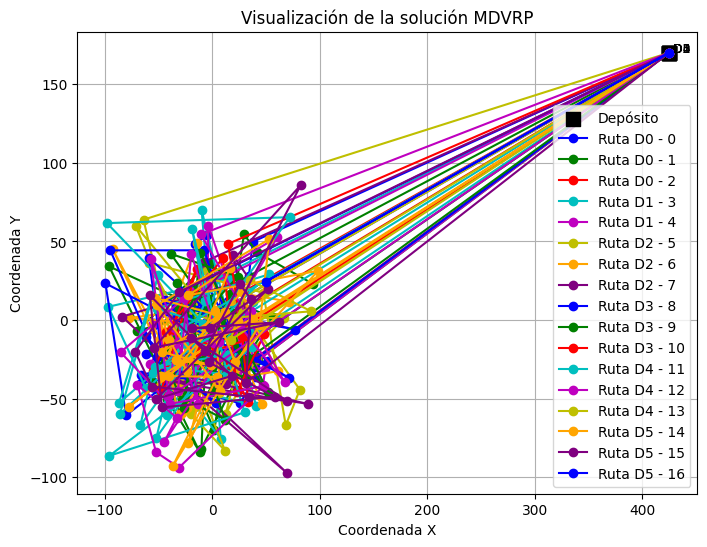

In [4]:
def visualize_solution(instance, solution):
    """
    Visualiza la solución: dibuja depósitos, clientes y las rutas para cada depósito.
    """
    depots = instance['depots']
    customers = instance['customers']
    cust_coords = {cust['id']: (cust['x'], cust['y']) for cust in customers}
    
    plt.figure(figsize=(8, 6))
    
    # Dibuja depósitos
    for i, depot in enumerate(depots):
        plt.scatter(depot[0], depot[1], marker='s', s=100, color='black', label="Depósito" if i == 0 else None)
        plt.text(depot[0], depot[1], f" D{i}", fontsize=9, color='black')
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'purple']
    color_index = 0
    # Dibuja rutas
    for depot_index, routes in solution.items():
        depot = depots[depot_index]
        for route_info in routes:
            if not route_info['route']:
                continue
            route_coords = [depot]
            for cust_id in route_info['route']:
                if cust_id in cust_coords:
                    route_coords.append(cust_coords[cust_id])
            route_coords.append(depot)
            xs = [pt[0] for pt in route_coords]
            ys = [pt[1] for pt in route_coords]
            plt.plot(xs, ys, marker='o', color=colors[color_index % len(colors)],
                     label=f"Ruta D{depot_index} - {color_index}")
            color_index += 1
    
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    plt.title("Visualización de la solución MDVRP")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    # Solicita el nombre del archivo .dat (se pregunta solo una vez)
    filename = input("Introduce el nombre del archivo .dat a usar (sin la extensión, si lo deseas): ").strip()
    if not os.path.exists(filename):
        filename_with_ext = filename + ".dat"
        if os.path.exists(filename_with_ext):
            filename = filename_with_ext
        else:
            print("El archivo no existe en el directorio actual.")
            exit(1)
    
    instance_data = read_mdvrp_dat(filename)
    print("\nInstancia cargada:")
    print("Header:", instance_data['header'])
    print("Depósitos:", instance_data['depots'])
    print("Número de clientes:", len(instance_data['customers']))
    
    brkga = BRKGA(instance_data, pop_size=50, elite_fraction=0.2, mutant_fraction=0.1, inheritance_prob=0.7, generations=100)
    best_fitness, best_solution = brkga.run()
    
    print("\nMejor solución encontrada:")
    print("Distancia total:", best_fitness)
    print("Solución (rutas por depósito):")
    for depot_index, routes in best_solution.items():
        print(f"Depósito {depot_index}:")
        for route in routes:
            print("  Ruta:", route['route'], "Distancia:", route['distance'], "Carga:", route['load'])
    
    visualize_solution(instance_data, best_solution)